# Bayesian Binary logistic regression in 2d for iris flowers
Code is based on: https://github.com/aloctavodia/BAP/blob/master/code/Chp4/04_Generalizing_linear_models.ipynb

author: @karm-patel

In [78]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns
import os


try:
    import blackjax
except:
    %pip install jaxopt blackjax
    import blackjax

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

from probml_utils.blackjax_utils import arviz_trace_from_states, inference_loop_multiple_chains
from sklearn.datasets import load_iris

try:
    from tensorflow_probability.substrates import jax as tfp
except ModuleNotFoundError:
    %pip install -qqq tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp

import arviz as az

tfd = tfp.distributions

In [79]:
# os.environ["LATEXIFY"] = ""
# os.environ["FIG_DIR"] = "figures"
pml.latexify(fig_height=1.75, width_scale_factor=2)

/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [80]:
iris = load_iris()
X = iris.data
y = iris.target

# Convert to pandas dataframe
df_iris = pd.DataFrame(data=iris.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
df_iris["species"] = pd.Series(iris.target_names[y], dtype="category")


df = df_iris.query("species == ('setosa', 'versicolor')")
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,versicolor
96,5.7,2.9,4.2,1.3,versicolor
97,6.2,2.9,4.3,1.3,versicolor
98,5.1,2.5,3.0,1.1,versicolor


## Balanced Dataset

In [81]:
df_balanced = df[25:75]
df_balanced.head()

,sepal_length,sepal_width,petal_length,petal_width,species
25,5.0,3.0,1.6,0.2,setosa
26,5.0,3.4,1.6,0.4,setosa
27,5.2,3.5,1.5,0.2,setosa
28,5.2,3.4,1.4,0.2,setosa
29,4.7,3.2,1.6,0.2,setosa


In [82]:
X = df_balanced[["sepal_length", "sepal_width"]].values  # features
X.shape

(50, 2)

In [83]:
y = pd.Categorical(df_balanced["species"]).codes
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int8)

In [84]:
bias_prior = tfd.Normal(0, 20)
weights_prior = tfd.Normal(0, 2)


def joint_logprob_fn(params, inputs=X, outputs=y):
    weights = params["weights"]
    bias = params["bias"]

    # prior logprob
    log_prior = weights_prior.log_prob(weights).sum() + bias_prior.log_prob(bias)

    # likelihood logprob
    logits = inputs @ weights + bias
    log_lik = tfd.Bernoulli(logits=logits).log_prob(outputs).sum()

    return log_prior + log_lik

In [85]:
# initialize the params for two chains
n_chains = 2
rng_key = jax.random.PRNGKey(10)
initial_params = {
    "weights": weights_prior.sample(seed=rng_key, sample_shape=(n_chains, 2)),
    "bias": bias_prior.sample(seed=rng_key, sample_shape=(n_chains,)),
}

In [86]:
inverse_mass_matrix = jnp.array([0.5] * 3)
step_size = 0.01
nuts = blackjax.nuts(joint_logprob_fn, step_size, inverse_mass_matrix)

In [87]:
initial_states = jax.vmap(nuts.init)(initial_params)
kernel = jax.jit(nuts.step)

In [88]:
%%time
rng_key = jax.random.PRNGKey(1)
states, infos = inference_loop_multiple_chains(rng_key, kernel, initial_states, 2000, n_chains)

CPU times: user 8.38 s, sys: 115 ms, total: 8.49 s
Wall time: 8.42 s


In [89]:
trace = arviz_trace_from_states(states, infos, burn_in=200)
summary_df = az.summary(trace)
summary_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bias,-10.299,5.970,-21.106,1.345,0.351,0.251,295.0,415.0,1.0
weights[0],4.185,1.042,2.226,6.045,0.053,0.038,392.0,515.0,1.0
weights[1],-4.017,1.146,-6.126,-1.827,0.040,0.029,822.0,1095.0,1.0


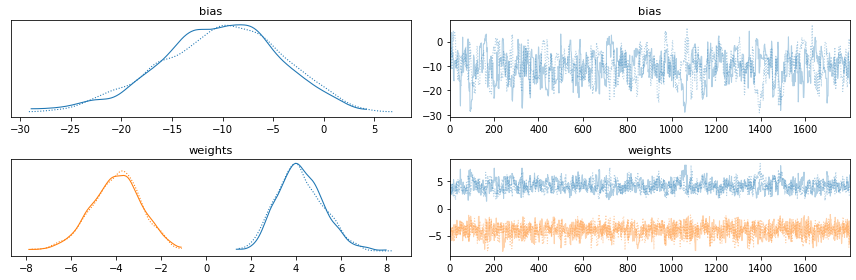

In [90]:
az.plot_trace(trace)
plt.tight_layout()

In [91]:
burn = 200
w0 = states.position["weights"][burn:, :, 0].reshape(1, -1)
w1 = states.position["weights"][burn:, :, 1].reshape(1, -1)
b = states.position["bias"][burn:, :].reshape(1, -1)

In [92]:
x0 = X[:, 0]
bd = -(jnp.dot(x0.reshape(-1, 1), w0) / w1 + b / w1)  # Decision boundary
bd.shape

(50, 3600)

/home/patel_karm/arviz/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


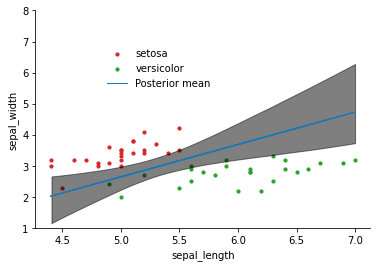

In [93]:
mean_pred = -(x0 * w0.mean() / w1.mean() + b.mean() / w1.mean())  # mean prediction

SCATTER_SIZE = 10
idx = y == 0

fig, ax = plt.subplots()

ax.scatter(X[idx, 0], X[idx, 1], c="tab:red", label="setosa", s=SCATTER_SIZE)
sc = ax.scatter(X[~idx, 0], X[~idx, 1], c="tab:green", label="versicolor", s=SCATTER_SIZE)

ax.set_xlabel("sepal_length")
ax.set_ylabel("sepal_width")
ax.set_ylim(1, 8)
ax.plot(x0, mean_pred, label="Posterior mean", lw=1)
az.plot_hdi(X[:, 0], bd.T, color="k", ax=ax)
ax.legend(frameon=False, bbox_to_anchor=(0.55, 0.6))
sns.despine()
pml.savefig("logreg_iris_bayes_2d")

## Unbalanced Dataset
Now we will use unbalanced dataset where we have only 5 samples of setosa and 45 samples of versicolor

In [94]:
df_un_balanced = df[45:95]
df_un_balanced.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
80,5.5,2.4,3.8,1.1,versicolor
73,6.1,2.8,4.7,1.2,versicolor
91,6.1,3.0,4.6,1.4,versicolor
56,6.3,3.3,4.7,1.6,versicolor
87,6.3,2.3,4.4,1.3,versicolor


In [95]:
X = df_un_balanced[["sepal_length", "sepal_width"]].values  # features
X.shape

(50, 2)

In [96]:
y = pd.Categorical(df_un_balanced["species"]).codes
y

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int8)

In [105]:
inverse_mass_matrix = jnp.array([0.5] * 3)
step_size = 0.01
joint_logprob_fn_partial = partial(joint_logprob_fn, inputs=X, outputs=y)
nuts = blackjax.nuts(joint_logprob_fn_partial, step_size, inverse_mass_matrix)

In [106]:
initial_states = jax.vmap(nuts.init)(initial_params)
kernel = jax.jit(nuts.step)

In [107]:
%%time
rng_key = jax.random.PRNGKey(1)
states, infos = inference_loop_multiple_chains(rng_key, kernel, initial_states, 2000, n_chains)

CPU times: user 8.7 s, sys: 103 ms, total: 8.8 s
Wall time: 8.73 s


In [108]:
trace = arviz_trace_from_states(states, infos, burn_in=200)
summary_df = az.summary(trace)
summary_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bias,-6.130,7.466,-20.525,6.788,0.517,0.366,216.0,265.0,1.01
weights[0],3.455,1.191,1.236,5.693,0.070,0.050,288.0,547.0,1.00
weights[1],-3.555,1.302,-6.184,-1.295,0.061,0.047,497.0,467.0,1.00


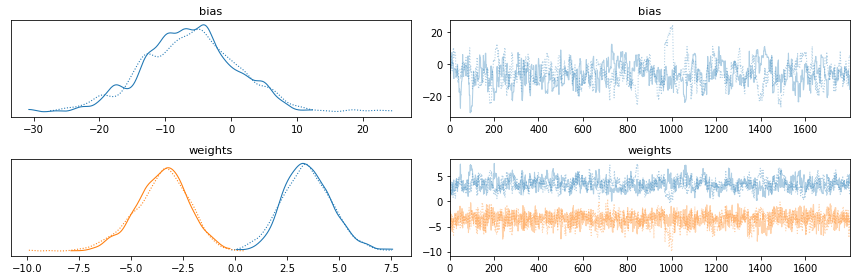

In [109]:
az.plot_trace(trace)
plt.tight_layout()

In [110]:
burn = 200
w0 = states.position["weights"][burn:, :, 0].reshape(1, -1)
w1 = states.position["weights"][burn:, :, 1].reshape(1, -1)
b = states.position["bias"][burn:, :].reshape(1, -1)

In [111]:
x0 = X[:, 0]
bd = -(jnp.dot(x0.reshape(-1, 1), w0) / w1 + b / w1)  # Decision boundary
bd.shape

(50, 3600)

/home/patel_karm/arviz/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/patel_karm/sendbox/probml-utils/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


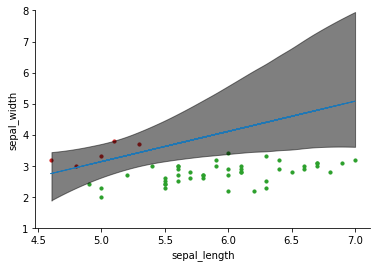

In [112]:
mean_pred = -(x0 * w0.mean() / w1.mean() + b.mean() / w1.mean())  # mean prediction

SCATTER_SIZE = 10
idx = y == 0

fig, ax = plt.subplots()

ax.scatter(X[idx, 0], X[idx, 1], c="tab:red", label="setosa", s=SCATTER_SIZE)
sc = ax.scatter(X[~idx, 0], X[~idx, 1], c="tab:green", label="versicolor", s=SCATTER_SIZE)

ax.set_xlabel("sepal_length")
ax.set_ylabel("sepal_width")
ax.set_ylim(1, 8)
ax.plot(x0, mean_pred, label="Posterior mean", lw=1)
az.plot_hdi(X[:, 0], bd.T, color="k", ax=ax)
# ax.legend(frameon=False, bbox_to_anchor=(0.55, 0.6))
sns.despine()
pml.savefig("logreg_iris_bayes_2d_unbalanced")